In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "D:\\MalariaDetection\\Cell_Images\\cell_images\\train"
test_path  = "D:\\MalariaDetection\\Cell_Images\\cell_images\\test"

In [4]:
image_shape = (130, 130, 3)

In [5]:
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1 ,
                               shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode = 'nearest')

In [6]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [7]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [8]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary')

Found 24958 images belonging to 2 classes.


In [9]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [10]:
VGG19_model = Sequential()

pretrained_model = tf.keras.applications.VGG19(include_top=False,
                   input_shape=image_shape,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

VGG19_model.add(pretrained_model)

VGG19_model.add(Flatten())
VGG19_model.add(Dense(128, activation='relu'))
VGG19_model.add(Dense(1, activation='sigmoid'))

In [11]:
VGG19_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,090,177
Trainable params: 65,793
Non-trainable params: 20,024,384
_________________________________________________________________


In [12]:
VGG19_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
VGG19_model.fit(train_image_gen, epochs=50, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/50
780/780 [==============================] - 82s 99ms/step - loss: 0.6933 - accuracy: 0.9003 - val_loss: 0.3532 - val_accuracy: 0.9223
Epoch 2/50
780/780 [==============================] - 73s 94ms/step - loss: 0.2703 - accuracy: 0.9219 - val_loss: 0.2058 - val_accuracy: 0.9315
Epoch 3/50
780/780 [==============================] - 74s 95ms/step - loss: 0.2014 - accuracy: 0.9324 - val_loss: 0.1892 - val_accuracy: 0.9350
Epoch 4/50
780/780 [==============================] - 74s 95ms/step - loss: 0.1817 - accuracy: 0.9365 - val_loss: 0.1680 - val_accuracy: 0.9350
Epoch 5/50
780/780 [==============================] - 74s 95ms/step - loss: 0.1669 - accuracy: 0.9412 - val_loss: 0.1751 - val_accuracy: 0.9396
Epoch 6/50
780/780 [==============================] - 74s 95ms/step - loss: 0.1643 - accuracy: 0.9413 - val_loss: 0.1846 - val_accuracy: 0.9281
Epoch 7/50
780/780 [==============================] - 74s 95ms/step - loss: 0.1660 - accuracy: 0.9412 - val_loss: 0.1838 - val_accuracy:

In [15]:
history = pd.DataFrame(VGG19_model.history.history)

In [16]:
history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693303,0.900272,0.353186,0.922308
1,0.270268,0.921909,0.205819,0.931538
2,0.201376,0.932406,0.189198,0.935000
3,0.181657,0.936453,0.168032,0.935000
4,0.166871,0.941181,0.175119,0.939615


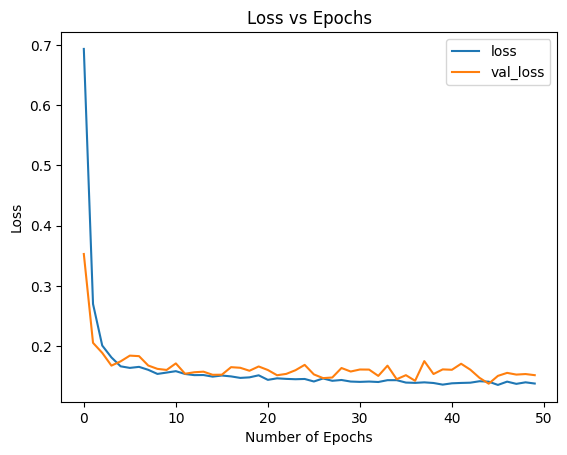

In [17]:
history[["loss", "val_loss"]].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig('LossVsEpochsVGG19.png')
plt.show()

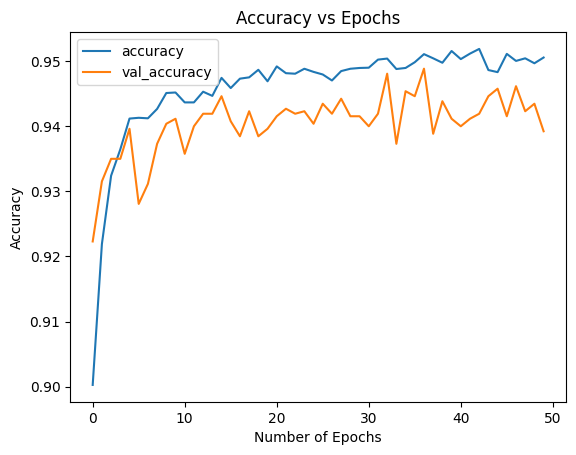

In [18]:
history[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig('AccuracyvsEpochsVGG19.png')
plt.show()

In [19]:
predictions = VGG19_model.predict(test_image_gen)

82/82 [==============================] - 7s 87ms/step


In [20]:
predictions = predictions >= 0.5

In [21]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [22]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1232,   68],
       [  68, 1232]], dtype=int64)

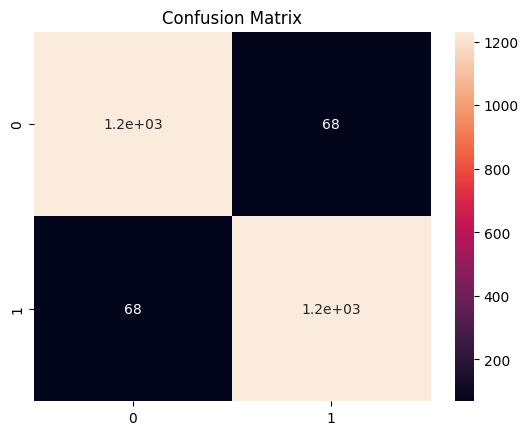

In [23]:
DetaFrame_cm = pd.DataFrame(confusion_matrix(test_image_gen.classes, predictions), range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True)
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrixHeatmapVGG19.png')
plt.show()

In [25]:
VGG19_model.save("MalariaPredictionsVGG19.h5")